In [1]:
import numpy as np
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
class Room():
    def __init__(self, shape):
        self.shape = np.array(shape, dtype=np.float64)

In [3]:
class FurnitureItem():    
    def __init__(self, unitcost, shape):
        self.unit_cost = unitcost
        self.shape = np.array(shape, dtype=np.float64)

In [4]:
class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [5]:
problems = []

In [6]:
with open('problems.rfp') as f:
  for line in f:
    furnitureList = []
    problem = line.replace(" ","").split("#")
    
    room_shape = problem[0].split(":")[1]
    furniture = problem[1].split(";")
    
    room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])
    
    for furnitureItem in furniture:
        parse_furniture = furnitureItem.strip().split(":")
        unit_cost = parse_furniture[0]
        shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
        furnitureItem = FurnitureItem(unit_cost, shape)
        furnitureList.append(furnitureItem)
    problems.append(Problem(room,furnitureList))


<IPython.core.display.Javascript object>


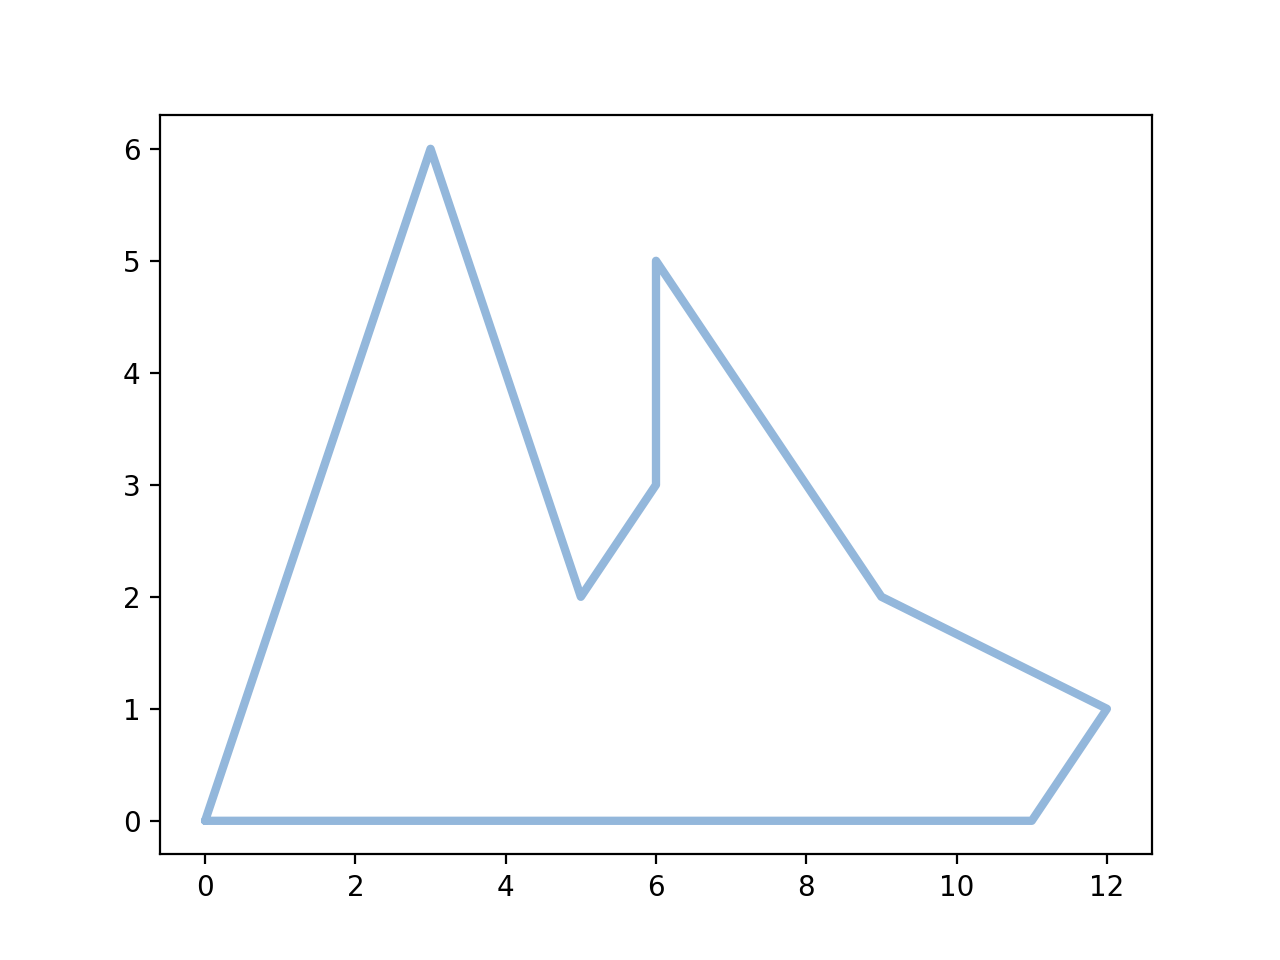

In [14]:
plt.figure(1)
poly = Polygon(problems[1].room.shape)
x,y = poly.exterior.xy
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
plt.show()

In [30]:
poly = Polygon(problems[1].furniture[0].shape)
x,y = poly.exterior.xy
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
plt.show()